# Environment

In [ ]:
!nvidia-smi

Tue Jun 15 15:12:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## clone darknet

In [ ]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15097, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 15097 (delta 8), reused 9 (delta 2), pack-reused 15072
Receiving objects: 100% (15097/15097), 13.49 MiB | 21.88 MiB/s, done.
Resolving deltas: 100% (10253/10253), done.


## compile

In [ ]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/content/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to run or train object detectors)
!make

## Util

In [ ]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

# chart
def chartShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(32, 20)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# Try YOLO 4 !!

## Get yolo v4 weight

In [ ]:
# Get yolov4 weights
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

## Test yolo v4

When you clone the darknet repo, you can use yolo v4 as well. Check directory ./darknet/cfg

In [ ]:
%pwd

'/content/darknet'

In [ ]:
# Test
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg
imShow('predictions.jpg')

# Real-time with your WEBCAM!

https://colab.research.google.com/drive/1xdjyBiY75MAVRSjgmiqI7pbRLn58VrbE?usp=sharing#scrollTo=RPDr23YFW_7c

## Import

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import matplotlib.pyplot as plt
%matplotlib inline
from darknet import *

In [ ]:
%pwd

'/content/darknet'

## Load network and weights

In [ ]:
network, class_names, class_colors = load_network("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)

# darknet helper function to run detection on image
def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  return detections, width_ratio, height_ratio

## utils

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  
  # call our darknet helper on webcam image
  detections, width_ratio, height_ratio = darknet_helper(img, width, height)

  # loop through detections and draw them on webcam image
  for label, confidence, bbox in detections:
    left, top, right, bottom = bbox2points(bbox)
    left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    cv2.rectangle(img, (left, top), (right, bottom), class_colors[label], 2)
    cv2.putText(img, "{} [{:.2f}]".format(label, float(confidence)),
                      (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                      class_colors[label], 2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Capture IMG

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## videos

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

# DATA

## Connet to Google Drive

In [ ]:
# Connect the Colab notebook to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## clone this repo

In [1]:
%cd /content
!git clone https://github.com/LinGeorge/Face_Mask_Detection_Darknet

/content
Cloning into 'Face_Mask_Detection_Darknet'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 88 (delta 17), reused 83 (delta 12), pack-reused 0
Unpacking objects: 100% (88/88), done.


In [2]:
!mv /content/Face_Mask_Detection_Darknet/ /content/Face_Mask_Detection_YOLO/

## Load Your Data

In [ ]:
# check your data
%cd /
from glob import glob
dataset_dir = "/content/gdrive/MyDrive/mask_detection_project/mask_dataset/"

img_list = glob(dataset_dir+'*.jpg')
# you should have images with labels.txt in same folder
print("your images :",len(img_list))

/
your images : 678


## Save train.txt / test.txt

In [ ]:
from sklearn.model_selection import train_test_split

train_img_list, val_img_list = train_test_split(img_list, test_size=0.1, random_state=42)

print(len(train_img_list), len(val_img_list))

610 68


In [ ]:
with open('/content/Face_Mask_Detection_YOLO/data/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list) + '\n')

with open('/content/Face_Mask_Detection_YOLO/data/val.txt', 'w') as f:
  f.write('\n'.join(val_img_list) + '\n')

print("Done")

Done


In [ ]:
raise

# Training


## Training

In [ ]:
%cd /content/darknet/
!wget https://pjreddie.com/media/files/darknet53.conv.74

/content/darknet
--2021-06-10 10:55:20--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  40.2MB/s    in 4.3s    

2021-06-10 10:55:25 (36.4 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



In [ ]:
# Mask training
%cd /content/darknet/
!./darknet detector train /content/Face_Mask_Detection_YOLO/MASK/object.data\
                          /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                          darknet53.conv.74\
                          -dont_show -map 

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.891836), count: 1, class_loss = 0.000000, iou_loss = 0.005375, total_loss = 0.005375 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.834014), count: 6, class_loss = 0.197333, iou_loss = 0.150215, total_loss = 0.347547 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.837032), count: 9, class_loss = 0.001807, iou_loss = 0.144564, total_loss = 0.146371 
 total_bbox = 2870265, rewritten_bbox = 0.054385 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.879328), count: 1, class_loss = 0.000003, iou_loss = 0.004637, total_loss = 0.004641 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.894990), count: 2, class_loss = 0.000000, iou_loss = 0.010019, total_loss = 0.010019 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.

## Checking the Mean Average Precision (mAP) of Your Model
If you didn't run the training with the '-map- flag added then you can still find out the mAP of your model after training. Run the following command on any of the saved weights from the training to see the mAP value for that specific weight's file. I would suggest to run it on multiple of the saved weights to compare and find the weights with the highest mAP as that is the most accurate one!

NOTE: If you think your final weights file has overfitted then it is important to run these mAP commands to see if one of the previously saved weights is a more accurate model for your classes.

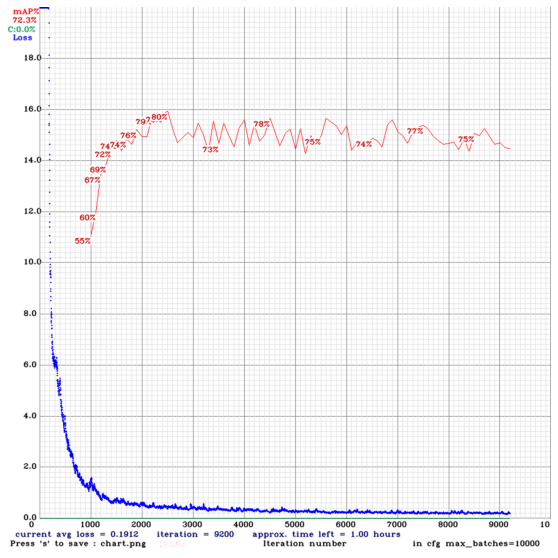

In [ ]:
# show chart.png of how custom object detector did with training
imShow('chart.png')

## kick off training

In [ ]:
# kick off training from where it last saved # load your trained weight
%cd /content/darknet/
!./darknet detector train /content/Face_Mask_Detection_YOLO/MASK/object.data\
                          /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                          /content/gdrive/MyDrive/mask_detection_project/weights/yolov3_mask_last.weights\
                          -dont_show -map 

# Detect!

In [ ]:
%cd /content/darknet/
!./darknet detector map /content/Face_Mask_Detection_YOLO/MASK/object.data\
                        /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                        /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights

/content/darknet
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x

## in Image

In [ ]:
from IPython.display import clear_output

In [ ]:
%cd /content/darknet/
!./darknet detector map /content/Face_Mask_Detection_YOLO/MASK/object.data\
                        /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                        /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
!./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                         /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                         /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                         /content/Face_Mask_Detection_YOLO/demo/man_0_1.png
clear_output()
imShow('predictions.jpg')
download('predictions.jpg')

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
!./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                         /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                         /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                         /content/Face_Mask_Detection_YOLO/demo/man_0_1.png
clear_output()
imShow('predictions.jpg')
download('predictions.jpg')

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
!./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                         /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                         /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                         /content/Face_Mask_Detection_YOLO/demo/two_2_0.png
clear_output()
imShow('predictions.jpg')
download('predictions.jpg')

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
!./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                         /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                         /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_last.weights\
                         /content/Face_Mask_Detection_YOLO/demo/woman-5772089_1280.jpg
clear_output()
imShow('predictions.jpg')
download('predictions.jpg')

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
for i in range(1, 26):
  !./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                          /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                          /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                          /content/gdrive/MyDrive/AI_Final/without_mask/{i}.jpg

  #!./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
  #                        /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
  #                        /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
  #                        /content/gdrive/MyDrive/AI_Final/without_mask/{image}.jpg
  #clear_output()
  imShow('predictions.jpg')
  !mv "/content/darknet/predictions.jpg" "/content/gdrive/MyDrive/AI_Final/without_mask/detected/{i}.jpg"
  #download('predictions.jpg')


In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
for i in range(1, 27):
  !./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                          /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                          /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                          /content/gdrive/MyDrive/AI_Final/with_mask/{i}.jpg

  #!./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
  #                        /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
  #                        /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
  #                        /content/gdrive/MyDrive/AI_Final/without_mask/{image}.jpg
  #clear_output()
  imShow('predictions.jpg')
  !mv "/content/darknet/predictions.jpg" "/content/gdrive/MyDrive/AI_Final/with_mask/detected/{i}.jpg"
  #download('predictions.jpg')

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
for i in range(1, 28):
  !./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                          /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                          /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                          /content/gdrive/MyDrive/AI_Final/mask_incorrectly/{i}.jpg

  #!./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
  #                        /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
  #                        /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
  #                        /content/gdrive/MyDrive/AI_Final/without_mask/{image}.jpg
  #clear_output()
  imShow('predictions.jpg')
  !mv "/content/darknet/predictions.jpg" "/content/gdrive/MyDrive/AI_Final/mask_incorrectly/detected/{i}.jpg"
  #download('predictions.jpg')

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
for i in range(1, 26):
  !./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                          /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                          /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                          /content/gdrive/MyDrive/mask_detection_project/special_mask_dataset/cloth_mask/cloth_{i}.jpg
  imShow('predictions.jpg')
  !mv "/content/darknet/predictions.jpg" "/content/gdrive/MyDrive/mask_detection_project/special_mask_dataset/cloth_mask/detected/{i}.jpg"
  #download('predictions.jpg')

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
for i in range(1, 26):
  !./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                          /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                          /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                          /content/gdrive/MyDrive/mask_detection_project/special_mask_dataset/n95_n99/n_{i}.jpg
  imShow('predictions.jpg')
  !mv "/content/darknet/predictions.jpg" "/content/gdrive/MyDrive/mask_detection_project/special_mask_dataset/n95_n99/detected/{i}.jpg"
  #download('predictions.jpg')

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
for i in range(1, 26):
  !./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                          /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                          /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                          /content/gdrive/MyDrive/mask_detection_project/special_mask_dataset/scarf/scarf_{i}.jpg
  imShow('predictions.jpg')
  !mv "/content/darknet/predictions.jpg" "/content/gdrive/MyDrive/mask_detection_project/special_mask_dataset/scarf/detected/{i}.jpg"
  #download('predictions.jpg')

In [ ]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
%cd /content/darknet/
for i in range(1, 26):
  !./darknet detector test /content/Face_Mask_Detection_YOLO/MASK/object.data\
                          /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                          /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                          /content/gdrive/MyDrive/mask_detection_project/special_mask_dataset/transparent/trans_{i}.jpg
  imShow('predictions.jpg')
  !mv "/content/darknet/predictions.jpg" "/content/gdrive/MyDrive/mask_detection_project/special_mask_dataset/transparent/detected/{i}.jpg"
  #download('predictions.jpg')

## in video

from loval 

In [ ]:
# upload the video of your choosing! (Feel free to use the same video I do, it is in the Github repository)
upload()

Saving 190312_32_StreetLife_HD_009_cropped.mp4 to 190312_32_StreetLife_HD_009_cropped.mp4
saved file 190312_32_StreetLife_HD_009_cropped.mp4


In [ ]:
!./darknet detector demo /content/Face_Mask_Detection_YOLO/MASK/object.data\
                         /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                         /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                         -dont_show\
                         /content/Face_Mask_Detection_YOLO/demo/190312_32_StreetLife_HD_009_cropped.mp4 -i 0 -out_filename results.avi

In [ ]:
# download the video with detections shown
download('results.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

from google drive

In [ ]:
!./darknet detector demo /content/Face_Mask_Detection_YOLO/MASK/object.data\
                         /content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg\
                         /content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights\
                         -dont_show\
                         /content/Face_Mask_Detection_YOLO/demo/190312_32_StreetLife_HD_009_cropped.mp4\
                         -i 0 -out_filename\
                         /content/gdrive/MyDrive/mask_detection_project/mask_demo/EX1.mp4
#clear_output()

## REAL TIME with YOUR WEBCAM!

In [ ]:
# set
your_model_cfg = "/content/Face_Mask_Detection_YOLO/MASK/detect_mask.cfg"
your_obj_data = "/content/Face_Mask_Detection_YOLO/MASK/object.data"
your_weight = "/content/gdrive/MyDrive/mask_detection_project/weights/detect_mask_best.weights" # modify the path here

network, class_names, class_colors = load_network(your_model_cfg, your_obj_data, your_weight)
width = network_width(network)
height = network_height(network)

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # call our darknet helper on video frame
    detections, width_ratio, height_ratio = darknet_helper(frame, width, height)

    # loop through detections and draw them on transparent overlay image
    for label, confidence, bbox in detections:
      left, top, right, bottom = bbox2points(bbox)
      left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
      bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
      bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
                        (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        class_colors[label], 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("/content/darknet/backup/detect_mask_last.weights")
files.download("/content/darknet/backup/detect_mask_best.weights")